In [1]:
# Google.colab drive integration
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# specify the desired data location to the current working directory
%cd /content/drive/MyDrive/Dataset

/content/drive/.shortcut-targets-by-id/1hQJhZXCBbc369GWFH06FCrflHQ8EO2xS/Dataset


In [3]:
# Keras prepocessing library
! pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00


In [5]:
# Get the required Library
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [6]:
# Training Data Path and Image gen (Normalization)
TRAINING_DIR = "/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Split_300/Training"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Validation Data Path and Image gen (Normalization)
VALIDATION_DIR = "/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Split_300/Validation"
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Training gen and batching
train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

# Validation gen and batching
validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

Found 3120 images belonging to 13 classes.
Found 780 images belonging to 13 classes.


In [7]:
# Just making sure the library to import things from G Drive Is present
from google.colab import drive
import os # Library to manipulate OS  I.E Copying, changing, and or reading things on folders

directoryTrain = '/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Training' # Change directory depending on your file's path
directoryVal = '/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Validation'

# List the contents of the directory
# Code to Check wether there is file's in the directory or not (Might be useful to debug)
try:
    files = os.listdir(directoryTrain)
    print("Files in directory:", files)
except FileNotFoundError:
    print(f"The directory {directoryTrain} does not exist.")

try:
    files = os.listdir(directoryVal)
    print("Files in directory:", files)
except FileNotFoundError:
    print(f"The directory {directoryVal} does not exist.")

Files in directory: ['Academic_Art', 'Art_Nouveau', 'Baroque', 'Expressionism', 'Japanese_Art', 'Neoclassicism', 'Primitivism', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Abstract']
Files in directory: ['Academic_Art', 'Art_Nouveau', 'Baroque', 'Expressionism', 'Japanese_Art', 'Neoclassicism', 'Primitivism', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Abstract']


In [8]:
class_indices = train_generator.class_indices
print(class_indices)

{'Abstract': 0, 'Academic_Art': 1, 'Art_Nouveau': 2, 'Baroque': 3, 'Expressionism': 4, 'Japanese_Art': 5, 'Neoclassicism': 6, 'Primitivism': 7, 'Realism': 8, 'Renaissance': 9, 'Rococo': 10, 'Romanticism': 11, 'Symbolism': 12}


#Model

In [27]:
def get_defined_label(x):
    label_dict = {'Abstract': 0, 'Academic_Art': 1, 'Art_Nouveau': 2, 'Baroque': 3, 'Expressionism': 4, 'Japanese_Art': 5, 'Neoclassicism': 6,
                  'Primitivism': 7, 'Realism': 8, 'Renaissance': 9, 'Rococo': 10, 'Romanticism': 11, 'Symbolism': 12}
    for key, value in label_dict:
        if key == x:
            return value

In [28]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

base_model = InceptionResNetV2(
        input_shape=(224,224,3),
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )
base_model.trainable = False

In [29]:
print('Base Model Ouput Shape = {}'.format(base_model.output_shape))
last_output = base_model.output

Base Model Ouput Shape = (None, 1536)


In [30]:
x = tf.keras.layers.Dropout(0.2)(last_output)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=13, activation='softmax')(x)

In [34]:
# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [35]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0002, momentum=0.9, centered=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [36]:
# Define callbacks
learning_rate_reduction = [
    ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=1,
        verbose=1,
        factor=0.25,
        min_lr=0.000003),
    EarlyStopping(
        monitor='val_loss',
        min_delta=0.001,
        patience=5,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True)
]

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=learning_rate_reduction
)

Epoch 1/10
98/98 [==============================] - 1829s 19s/step - loss: 2.3036 - accuracy: 0.2356 - val_loss: 1.9151 - val_accuracy: 0.3385 - lr: 2.0000e-04
Epoch 2/10
98/98 [==============================] - 158s 2s/step - loss: 1.9298 - accuracy: 0.3442 - val_loss: 1.6835 - val_accuracy: 0.4333 - lr: 2.0000e-04
Epoch 3/10
98/98 [==============================] - 153s 2s/step - loss: 1.8271 - accuracy: 0.3772 - val_loss: 1.6505 - val_accuracy: 0.4449 - lr: 2.0000e-04
Epoch 4/10
98/98 [==============================] - 154s 2s/step - loss: 1.7092 - accuracy: 0.4311 - val_loss: 1.5690 - val_accuracy: 0.4910 - lr: 2.0000e-04
Epoch 5/10
98/98 [==============================] - ETA: 0s - loss: 1.6855 - accuracy: 0.4369
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
98/98 [==============================] - 151s 2s/step - loss: 1.6855 - accuracy: 0.4369 - val_loss: 1.6562 - val_accuracy: 0.4436 - lr: 2.0000e-04
Epoch 6/10
98/98 [==============================]

#Save Model

In [38]:
# Save the model
model.save('model5_ArtNaon.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# You can also use this cell as a shortcut for downloading your model
from google.colab import files
files.download("model5_ArtNaon.h5")

#Grafik

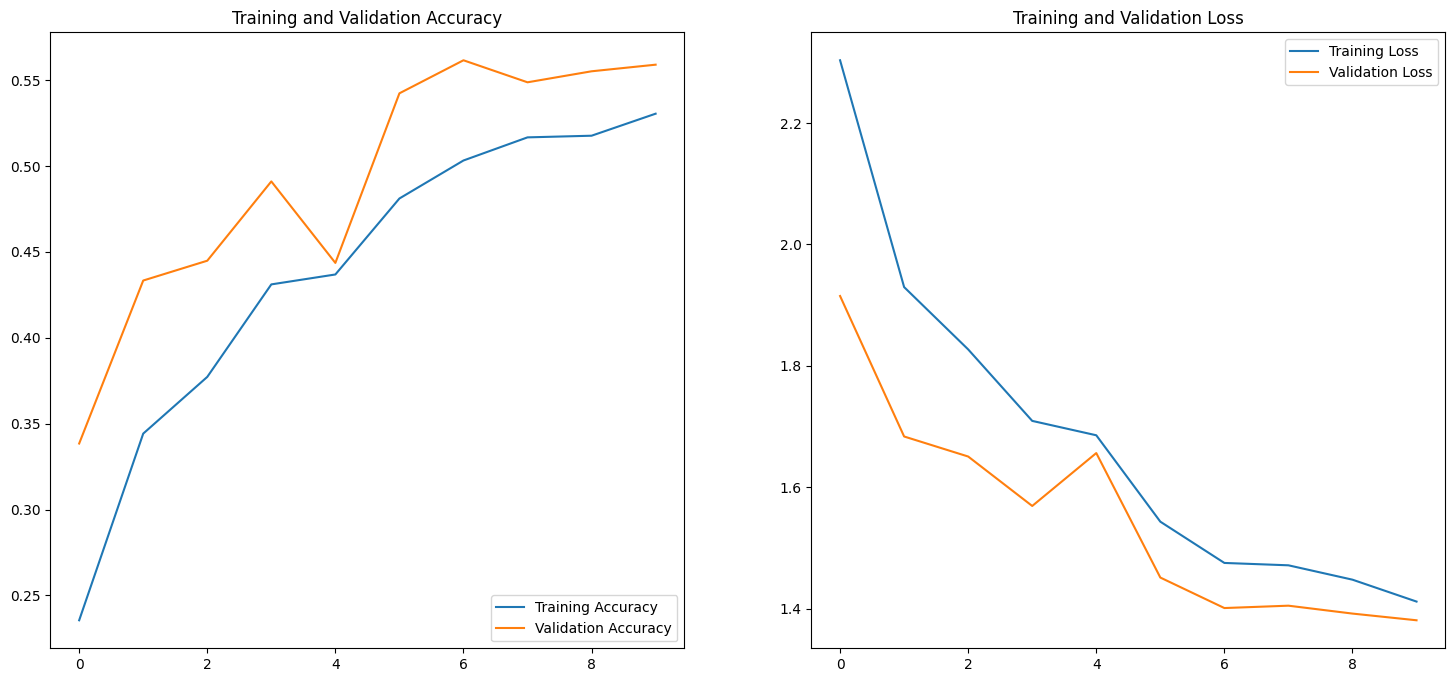

In [39]:
#Grafik
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 10
epochs_range = range(epochs)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Training

1/1 [==============================] - 4s 4s/step


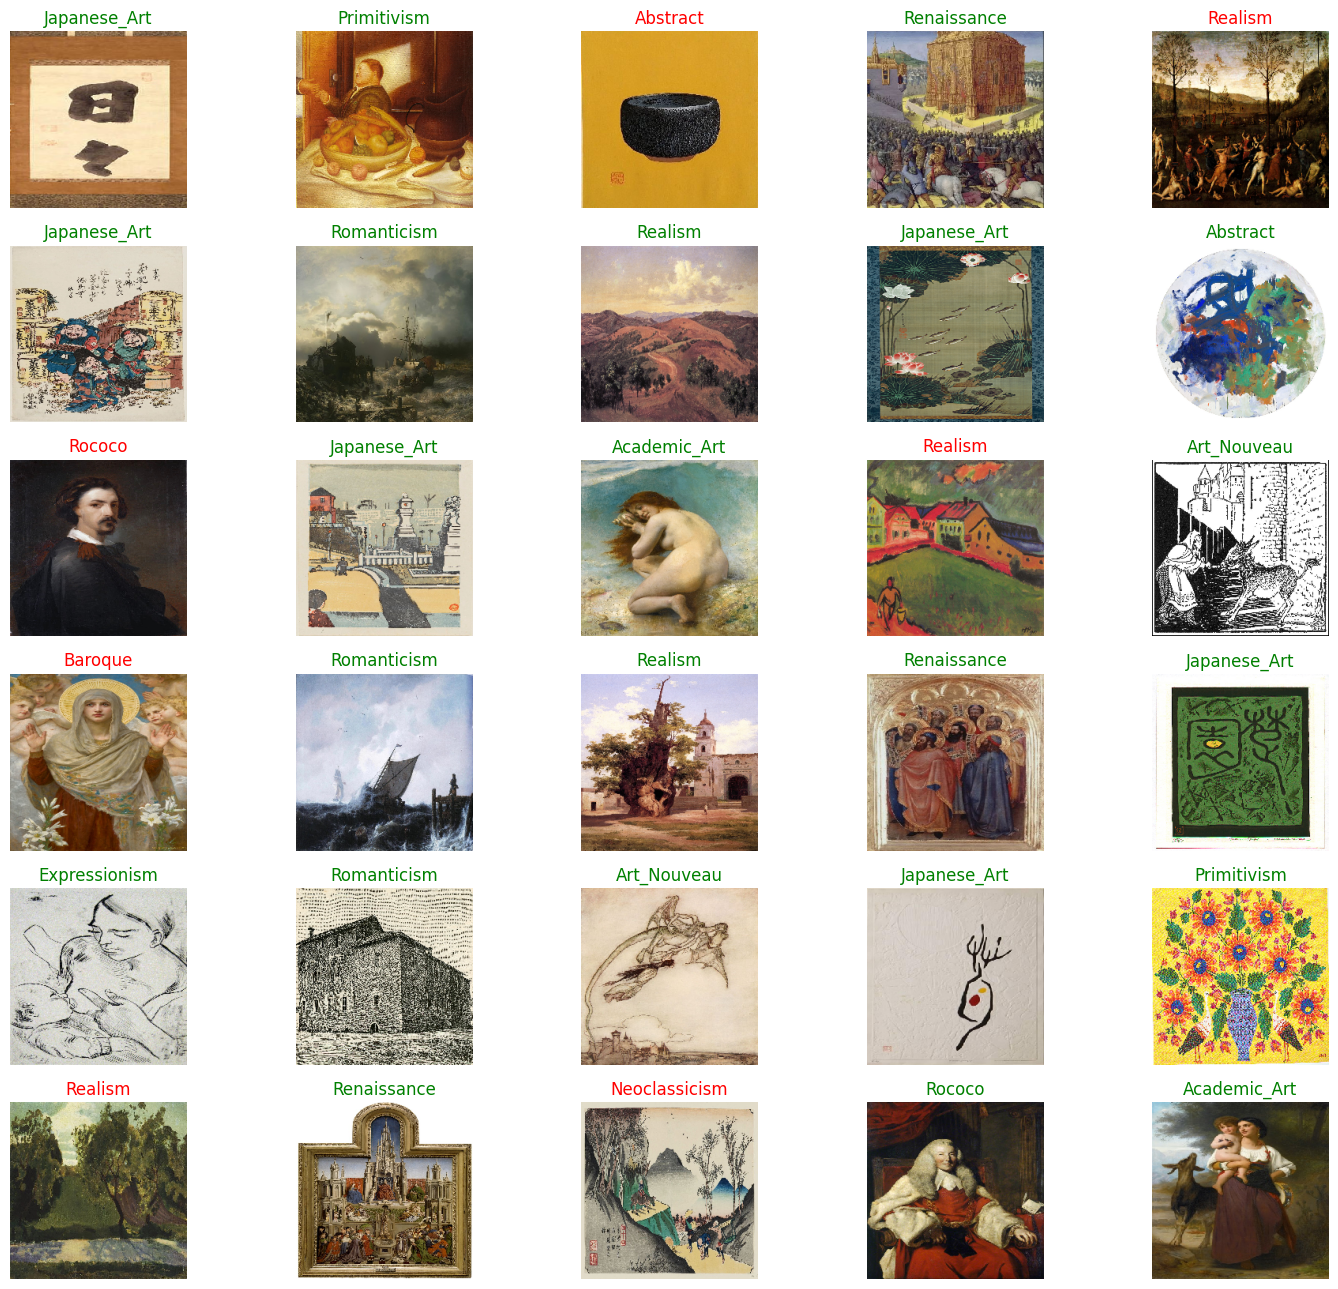

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/model5_ArtNaon.h5')

# Assuming validation_generator is already set up and is part of the code that was provided
# Make sure to use the correct directory for the validation data
# validation_generator = ...

# Get a batch of images from the validation generator
img, labels = next(validation_generator)

# Define the class indices (mapping) as obtained previously
class_indices = {'Abstract': 0, 'Academic_Art': 1, 'Art_Nouveau': 2, 'Baroque': 3, 'Expressionism': 4, 'Japanese_Art': 5, 'Neoclassicism': 6,
                 'Primitivism': 7, 'Realism': 8, 'Renaissance': 9, 'Rococo': 10, 'Romanticism': 11, 'Symbolism': 12}
# Reverse the class indices dictionary to map indices to class names for display
indices_class = {v: k for k, v in class_indices.items()}

# Predict the class of each image in the batch
predictions = model.predict(img)

# Set up the figure for plotting images
plt.figure(figsize=(15, 13))

# Plot each image in the batch
for i in range(30):  # Assuming you want to plot 30 images
    ax = plt.subplot(6, 5, i + 1)  # Adjust the number of rows and cols accordingly
    plt.imshow(img[i])

    # Get the predicted and true labels
    predicted_label = indices_class[np.argmax(predictions[i])]
    true_label = indices_class[np.argmax(labels[i])]

    # Set the title of each plot to the predicted label
    # If the prediction is correct, the title is set in green; otherwise, it's set in red
    title_color = 'green' if predicted_label == true_label else 'red'
    plt.title(predicted_label, color=title_color)
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()